[17932, 14886, 9813, 12793, 27093, 27976, 19286, 25868, 22690, 4900, 13215, 31380, 18494, 1362, 8105, 14263, 15015, 4131, 1053, 23300]
 loss test nag: 0.25
 loss test nag: 0.18855463972
 loss test nag: 0.165688637024
 loss test nag: 0.152678542648
 loss test nag: 0.144398845759
 loss test nag: 0.1386335111
 loss test nag: 0.126854308668
 loss test nag: 0.132970703194
 loss test nag: 0.126855854898
 loss test nag: 0.124537175593
 loss test nag: 0.124031651071
 loss test nag: 0.118678756982
 loss test nag: 0.122127388174
 loss test nag: 0.119671183489
 loss test nag: 0.123385719546
 loss test nag: 0.123068521378
 loss test nag: 0.119749565773
 loss test nag: 0.120015645663
 loss test nag: 0.113493799753
 loss test nag: 0.117099693901
 loss test nag: 0.115770147295
 loss test nag: 0.112124186643
 loss test nag: 0.115614909335
 loss test nag: 0.11510078862
 loss test nag: 0.113547687407
 loss test nag: 0.115640939097
 loss test nag: 0.113968398356
 loss test nag: 0.115099222368
 loss test 

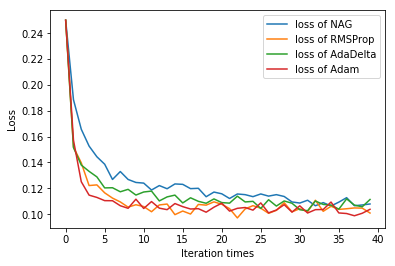

In [2]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import math

eta = 0.05 # Learning Rate
epsilon = 0.00001 #using in 4 optimalization methods to prevent the denominator become 0
iter = 40 # Iteration times
accuracy = 0.001 # If loss<accuracy , then stop iteration
mini_batch_percent = 0.2

m_train = 32561 # Amount of training data
m_test = 16281 # Amount of testing data
features=123 # Fearures of dataset

#Initialize arrays
w= [0]*features #All zero initialization

#used to stastic and draw graph
iter_num = [0]*iter;
loss_train  = [0]*iter;
loss_test_nag  = [0]*iter;
loss_test_rmsprop  = [0]*iter;
loss_test_adadelta  = [0]*iter;
loss_test_adam  = [0]*iter;


#used in adadelta
sum_of_x_squared = 0
sum_of_grad_squared = 0
current = 0

#used in adam
mt = np.zeros(features)
vt =0 
beta1 = 0.9
beta2 = 0.999

#used in rmsProp
Eg2 = 0

#used in NAG
v = np.zeros(features)
miu = 0.9

def  squared(vector):
    a = np.mat(vector)
    b = a*a.T
    return b[0][0]

#Use to get dataset from file
def get_data():
    data_train = load_svmlight_file("dataset\\a9a",n_features=features)
    X_train = data_train[0].toarray()
    y_train = data_train[1]
    data_test = load_svmlight_file("dataset\\a9a.t",n_features=features)
    X_test = data_test[0].toarray()
    y_test = data_test[1]
    return X_train, y_train, X_test, y_test

#The linear model, hw(x) = g(w.T * x)
def hypothesis(x):
    global w
    z =   np.mat(x) * np.mat(w).T
    z = z[0,0]
    result = 1.0 / (1+(np.e**(-z)))
    return result


#Loss function 
def loss(m,X,y):
    global w
    result = 0.0
    w2 = np.mat(w)
    for i in range (0,m):
        x = np.mat(X[i])
        result += np.log(1+np.e**(-(X[i] * w2.T)[0,0]*y[i]))
    result = result /m 
    return result

def simple_loss(m,X,y):
    global w
    result = 0.0
    
    sample_num =math.ceil( m * mini_batch_percent)
    target=random.sample(range(0,m),sample_num)
    w2 = np.mat(w)
    
    for index in range (0,sample_num):
        i = target[index]
        x = np.mat(X[i])
        result += ( hypothesis(X[i]) - (y[i]+1)/2 ) ** 2
        
    result = result / sample_num 
    return result

#mini -batch loss function  
def SGD_loss(m,X,y):
    global w
    result = 0.0
    
    sample_num =math.ceil( m * mini_batch_percent)
    target=random.sample(range(0,m),sample_num)
    w2 = np.mat(w)
    
    for index in range (0,sample_num):
        i = target[index]
        x = np.mat(X[i])
        result += np.log(1+np.e**(-(X[i] * w2.T)[0,0]*y[i]))
        
    result = result / sample_num 
    return result


def update(m,X,y,method):
    global w
    if (method=='nag'):
        grad = SGD_grad(m,X,y)
        w = w + NAG(grad)
    if (method=='rmsprop'):
        grad = SGD_grad(m,X,y)
        w = w + rmsProp(grad)
    if (method=='adadelta'):
        grad = SGD_grad(m,X,y)
        w = w + adadelta(grad)
    if (method=='adam'):
        grad = SGD_grad(m,X,y)
        w = w + adam(grad)
    
def raw(grad):
    return -eta * grad


def adadelta(grad):
    global sum_of_grad_squared, sum_of_x_squared, current
    sum_of_grad_squared += squared(grad)
    grad2 = np.mat(grad)
    delta_x_mat =  -1* grad2
    
    if(current==0):
        current+=1
        delta_x_mat = -1*  grad2
    else:
        RMS_delta_x = math.sqrt(sum_of_x_squared/current)
        RMS_grad = math.sqrt(sum_of_grad_squared/(current+1))
        alpha = -1.0 * ( RMS_delta_x / RMS_grad)
        delta_x_mat = alpha * grad2
        current+=1
    sum_of_x_squared += squared(delta_x_mat.getA1())
    
    
    return delta_x_mat.getA1()

def adam(grad):
    global beta1,beta2,mt,vt,epsilon,current
    current+=1
    delta_x = [0]*features
    grad2 = np.mat(grad)
    mt = beta1 * mt + (1-beta1)*(grad2)
    vt = beta2 * vt + (1-beta2)*( (grad2 * grad2.T)[0,0])
    delta_x_mat = -eta * (math.sqrt(1-beta2**current)/(1-beta1**current))*(mt/(math.sqrt(vt)+epsilon)) 
    
    return delta_x_mat.getA1()
    
def rmsProp(grad):
    global Eg2
    grad2 = np.mat(grad)
    gt2 = (grad2 * grad2.T)[0,0]
    Eg2 =  0.9 * Eg2 + 0.1 * gt2
    delta_x_mat =  -eta / (math.sqrt(Eg2+epsilon)) *(grad2)
    return delta_x_mat.getA1()
    
def NAG(grad):
    global v,eta,miu
    grad2 = np.mat(grad)
    v = miu * v  - eta * grad2
    return v.getA1()
    

#Derivative the Loss function to get Gradient (G) of theta j
def grad(m,X,y):
    result = np.zeros(features);
    for i in range (0,m):
        result +=  (hypothesis(X[i]) - (y[i]+1)/2) *X[i]
    result = result / m
    return result

#Derivative the Loss function to get Gradient (G) of theta j
def SGD_grad(m,X,y):
    result = np.zeros(features);
    
    sample_num =math.ceil( m * mini_batch_percent)
    #target = np.random.permutation(m)[0:sample_num]
    target=random.sample(range(0,m),sample_num)
    for index in range (0,sample_num):
        i = target[index]
        result +=  (hypothesis(X[i]) - (y[i]+1)/2)*X[i]
        
    result = result / m
    return result


#Train and validate 
def trainAndTest():
    global w
    
    for i in range (0,iter):
        iter_num[i] = i;
                   
        loss_test_nag[i] =  simple_loss(m_test,X_test,y_test)
        print(" loss test nag:",loss_test_nag[i]);
        
        for j in range (0,10):
            update(m_train,X_train,y_train,'nag')
    
    w = [0]*features
  
    for i in range (0,iter):
        iter_num[i] = i;
                   
        loss_test_rmsprop[i] =  simple_loss(m_test,X_test,y_test)
        print(" loss test rmsProp:",loss_test_rmsprop[i]);
        
        for j in range (0,10):
            update(m_train,X_train,y_train,'rmsprop')
    
    w = [0]*features    
    
    for i in range (0,iter):
        iter_num[i] = i;

        loss_test_adadelta[i] =  simple_loss(m_test,X_test,y_test)
        print(" loss test adadelta:", loss_test_adadelta[i]);
        
        for j in range (0,10):
            update(m_train,X_train,y_train,'adadelta')
    
    w = [0]*features
            
    for i in range (0,iter):
        iter_num[i] = i;
                   
        loss_test_adam[i] =  simple_loss(m_test,X_test,y_test)
        print(" loss test adam:",loss_test_adam[i]);
        
        for j in range (0,10):
            update(m_train,X_train,y_train,'adam')
      
#test
resultList=random.sample(range(0,m_train),20)
print(resultList)


#Main 
X_train, y_train, X_test, y_test = get_data()

'''
m_train = 100
X_train = X_train[0:100]
y_train = y_train[0:100]
'''
trainAndTest()



#Print the information and draw graphs
print("Features:",w)
fig, ax = plt.subplots()
ax.plot(iter_num, loss_test_nag,  label='loss of NAG')
ax.plot(iter_num, loss_test_rmsprop,  label='loss of RMSProp')
ax.plot(iter_num, loss_test_adadelta,  label='loss of AdaDelta')
ax.plot(iter_num, loss_test_adam,  label='loss of Adam')
plt.legend(bbox_to_anchor=[1, 1])  
ax.set_xlabel('Iteration times')
ax.set_ylabel('Loss')
plt.show()  

